    ZCTA             label         NAME  population  under_18_pct  \
0  35091  Kimberly (35091)  ZCTA5 35091        3632          25.6   
1  35116    Morris (35116)  ZCTA5 35116        4912          26.2   
2  35180   Warrior (35180)  ZCTA5 35180       14097          27.4   

   age_65plus_pct  male_pct  female_pct  median_hh_income  labor_force_pct  \
0            13.0      46.8        53.2             93444             76.9   
1            15.8      47.6        52.4             98990             65.4   
2            16.4      50.2        49.8             71281             57.2   

   unemp_rate_pct  owner_occ_pct  median_home_value  median_gross_rent  
0             2.1           94.3             284900                889  
1             2.4           92.3             228200                844  
2             5.3           85.9             198600                895  
Wrote: C:\Users\alexmca\Documents\GitHub\KimberlyAL_AnalyticsDataSnapshot\charts\acs_2023_profile_ZCTA_35091_35116_351

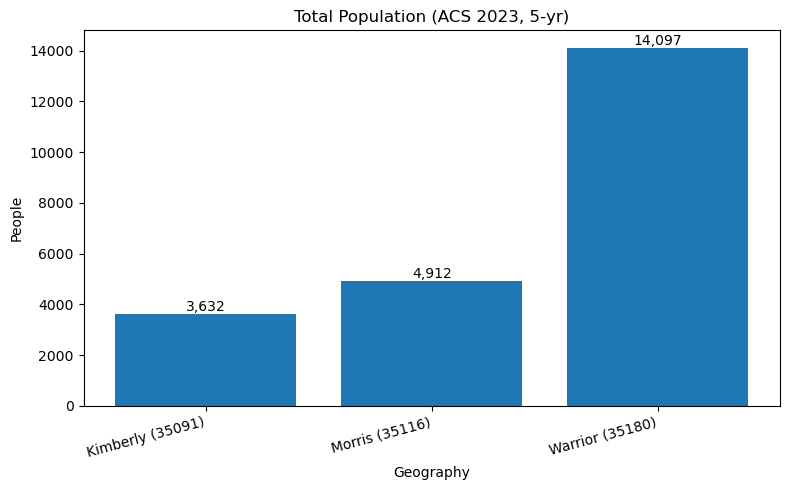

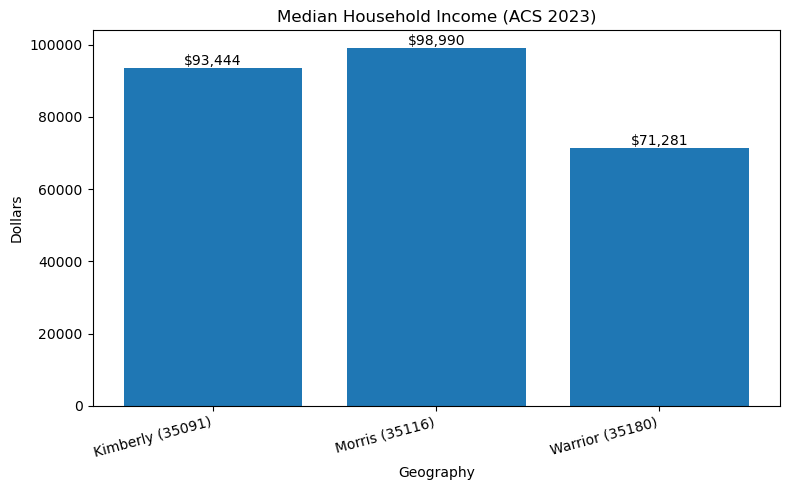

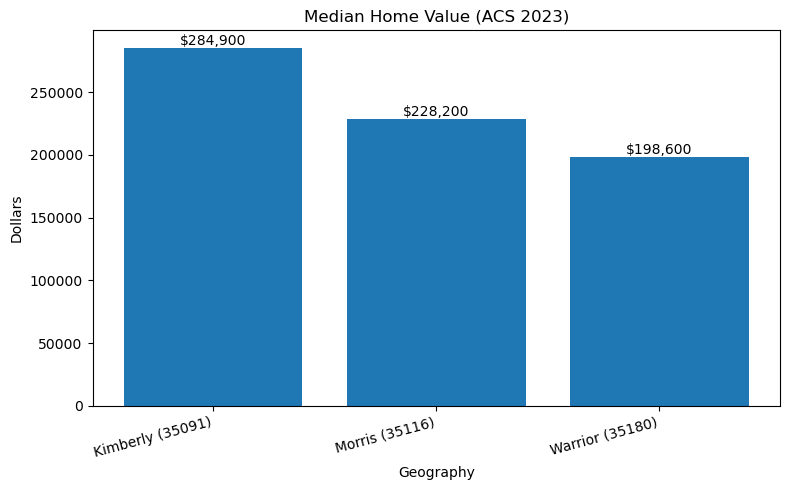

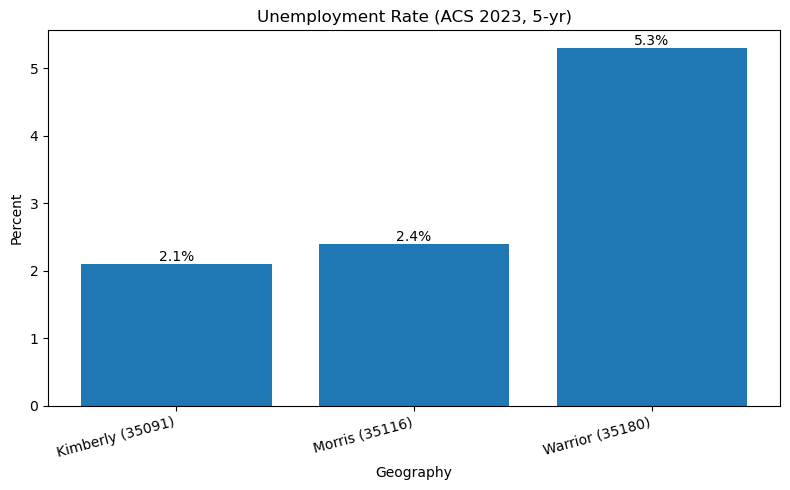

Charts saved to: C:\Users\alexmca\Documents\GitHub\KimberlyAL_AnalyticsDataSnapshot\charts


In [9]:
# One-and-done ACS fetch + save + charts (with friendly town labels)

from pathlib import Path
import os, requests, pandas as pd
import matplotlib.pyplot as plt

# -------------------
# Config
# -------------------
OUT_DIR = Path(r"C:/Users/alexmca/Documents/GitHub/KimberlyAL_AnalyticsDataSnapshot/charts")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ZCTAs (ZIP Code Tabulation Areas)
ZIPS = ["35091", "35116", "35180"]

# Friendly labels for charts/CSV
FRIENDLY_LABELS = {
    "35091": "Kimberly (35091)",
    "35116": "Morris (35116)",
    "35180": "Warrior (35180)",
}

# ACS 2023 5-year Data Profile endpoint
BASE = "https://api.census.gov/data/2023/acs/acs5/profile"

# Variable map (NAME is useful for QA)
VAR_MAP = {
    "NAME": "NAME",
    # DP05 (demographics)
    "population": "DP05_0001E",
    "under_18_pct": "DP05_0019PE",
    "age_65plus_pct": "DP05_0024PE",
    "male_pct": "DP05_0002PE",
    "female_pct": "DP05_0003PE",
    # DP03 (economic)
    "median_hh_income": "DP03_0062E",
    "labor_force_pct": "DP03_0002PE",
    "unemp_rate_pct": "DP03_0009PE",
    # DP04 (housing)
    "owner_occ_pct": "DP04_0046PE",
    "median_home_value": "DP04_0089E",
    "median_gross_rent": "DP04_0134E",
}

plt.rcParams["figure.figsize"] = (8, 5)

# -------------------
# Fetch helper
# -------------------
def fetch_acs_zcta(zips, var_map, api_key=None) -> pd.DataFrame:
    get_clause = ",".join(var_map.values())
    params = {"get": get_clause, "for": f"zip code tabulation area:{','.join(zips)}"}
    if api_key:
        params["key"] = api_key

    r = requests.get(BASE, params=params, timeout=60)
    try:
        r.raise_for_status()
    except Exception as e:
        print("⚠️ HTTP error:", e)
        print("Response text:", r.text[:500])
        return pd.DataFrame()

    try:
        data = r.json()
    except Exception as e:
        print("⚠️ JSON parse error:", e, "| First 500 chars:", r.text[:500])
        return pd.DataFrame()

    if not data or len(data) < 2:
        print("⚠️ Empty response from API.")
        return pd.DataFrame()

    df = pd.DataFrame(data[1:], columns=data[0])

    # Rename columns to friendly names
    inv = {v: k for k, v in var_map.items()}
    df = df.rename(columns=inv).rename(columns={"zip code tabulation area": "ZCTA"})

    # Coerce numeric fields
    num_cols = [
        "population","under_18_pct","age_65plus_pct","male_pct","female_pct",
        "median_hh_income","labor_force_pct","unemp_rate_pct",
        "owner_occ_pct","median_home_value","median_gross_rent"
    ]
    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # Add friendly label column
    df["label"] = df["ZCTA"].map(FRIENDLY_LABELS).fillna(df["ZCTA"])

    # Keep order of ZIPS provided
    df = df.set_index("ZCTA").loc[zips].reset_index()

    return df

API_KEY = os.environ.get("CENSUS_KEY")  # optional but helps avoid rate limits

# -------------------
# Fetch + save
# -------------------
acs = fetch_acs_zcta(ZIPS, VAR_MAP, api_key=API_KEY)

if acs.empty:
    print("No ACS rows returned. Check network, try again, or set a Census API key in env var CENSUS_KEY.")
else:
    # Reorder/select useful columns
    cols = [
        "ZCTA","label","NAME",
        "population","under_18_pct","age_65plus_pct","male_pct","female_pct",
        "median_hh_income","labor_force_pct","unemp_rate_pct",
        "owner_occ_pct","median_home_value","median_gross_rent"
    ]
    acs = acs[[c for c in cols if c in acs.columns]]
    print(acs.head())

    out_csv = OUT_DIR / "acs_2023_profile_ZCTA_35091_35116_35180.csv"
    acs.to_csv(out_csv, index=False)
    print("Wrote:", out_csv)

    # -------------------
    # Chart helper (adds labels and value annotations)
    # -------------------
    def bar_compare(df, value_col, title, ylab, fname, kind="number"):
        df2 = df.copy()
        labels = df2["label"].tolist()
        vals = df2[value_col].tolist()

        fig = plt.figure()
        ax = plt.gca()
        ax.bar(range(len(labels)), vals)
        ax.set_title(title)
        ax.set_xlabel("Geography")
        ax.set_ylabel(ylab)
        ax.set_xticks(range(len(labels)))
        ax.set_xticklabels(labels, rotation=15, ha="right")

        # Annotate bar tops with values
        for i, v in enumerate(vals):
            if pd.notna(v):
                if kind == "dollar":
                    txt = f"${v:,.0f}"
                elif kind == "percent":
                    txt = f"{v:.1f}%"
                else:
                    txt = f"{v:,.0f}"
                ax.text(i, v, txt, ha="center", va="bottom")

        plt.tight_layout()
        plt.savefig(OUT_DIR / fname, dpi=200)
        plt.show()

    # -------------------
    # Make charts
    # -------------------
    bar_compare(acs, "population",          "Total Population (ACS 2023, 5-yr)",   "People",   "acs_pop.png",          kind="number")
    bar_compare(acs, "median_hh_income",    "Median Household Income (ACS 2023)",  "Dollars",  "acs_income.png",       kind="dollar")
    bar_compare(acs, "median_home_value",   "Median Home Value (ACS 2023)",        "Dollars",  "acs_home_value.png",   kind="dollar")
    bar_compare(acs, "unemp_rate_pct",      "Unemployment Rate (ACS 2023, 5-yr)",  "Percent",  "acs_unemployment.png", kind="percent")

    print("Charts saved to:", OUT_DIR)

# Note to include in your post/caption if helpful:
# "ZCTAs are the Census' ZIP-based areas and may not match exact city limits."